# Library

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

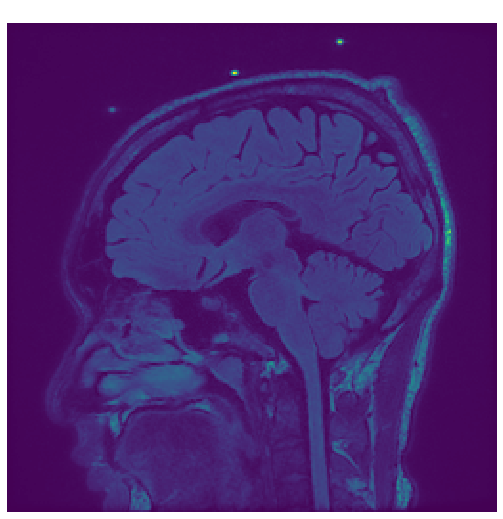

In [4]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
d = pydicom.read_file(basepath + "Z103")
file = np.array(d.pixel_array)
img = file

img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

ShowImage('Gambar',img,'rgb')

# Adaptive Mean

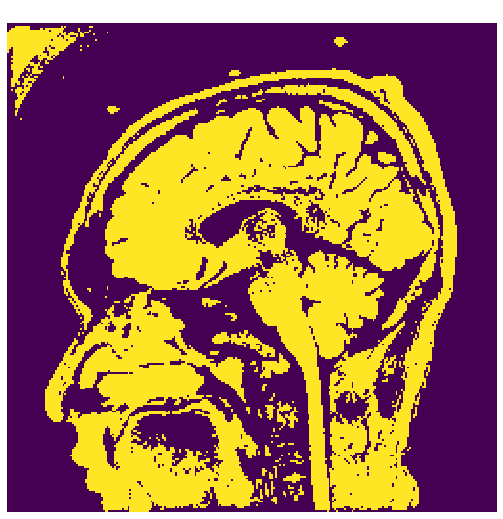

In [5]:
adaptiveMean = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,115, 1)
ShowImage('adaptiveMean',adaptiveMean,'rgb')

# Erosion from adaptiveMean

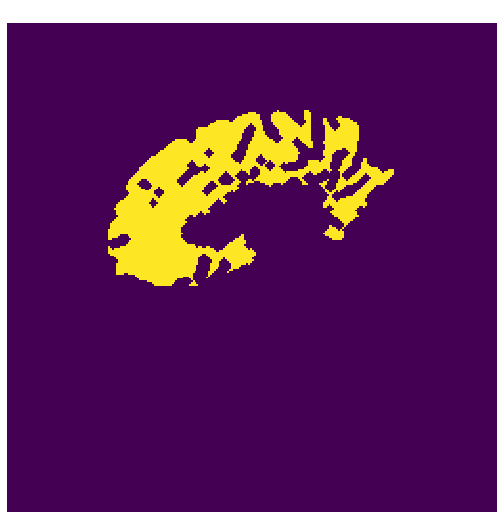

In [8]:
# kernel = np.ones((5, 5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
erosion = cv2.erode(adaptiveMean,kernel,iterations = 2)

foreground_value = 255
mask = np.uint8(erosion == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
erosion = np.zeros_like(erosion)
erosion[labels == largest_label] = foreground_value
ShowImage('erosion',erosion,'rgb')

# Closing from Erosion

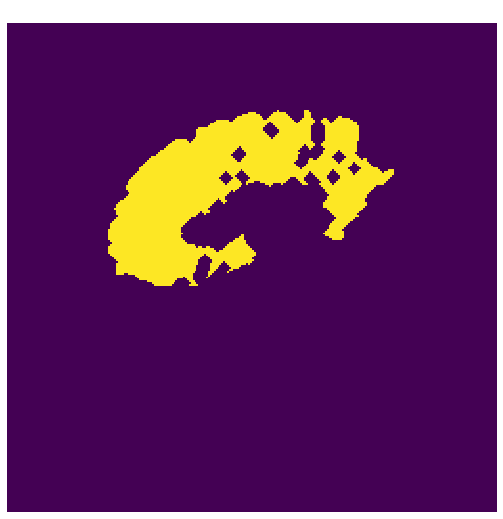

In [12]:
# kernel = np.ones((5, 5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel, iterations= 3)

foreground_value = 255
mask_closing = np.uint8(closing >= foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_closing, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
closing = np.zeros_like(closing)
closing[labels == largest_label] = foreground_value
ShowImage('closing',closing,'rgb')

# dilation from Erosion

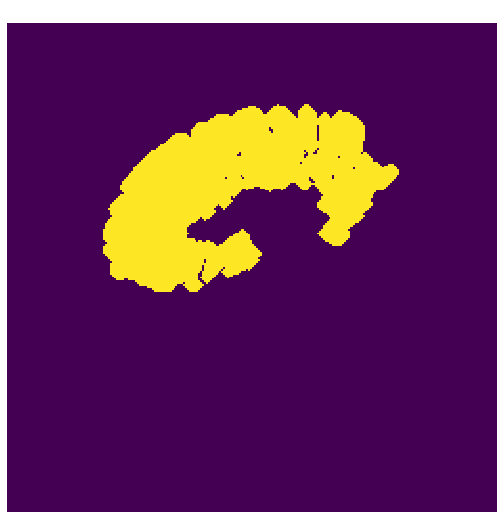

In [16]:
# shape = np.ones((5, 5), np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
dilation = cv2.dilate(closing,kernel,iterations = 3)

foreground_value = 255
mask = np.uint8(dilation == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
dilation = np.zeros_like(dilation)
dilation[labels == largest_label] = foreground_value
ShowImage('dilation',dilation,'rgb')

# Skull Stripping

In [17]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = dilation)
brain_pixels = skull_stripped_image[dilation == foreground_value]

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

(3, 50, 0.01) criteria Paramaters


# Segmented Image

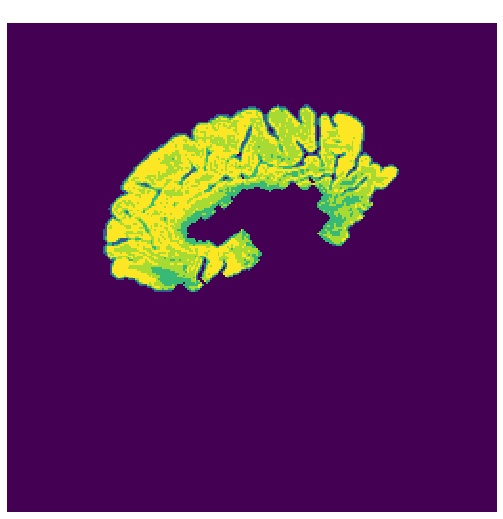

In [18]:
segmented_image = np.zeros_like(dilation)
segmented_image[dilation == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

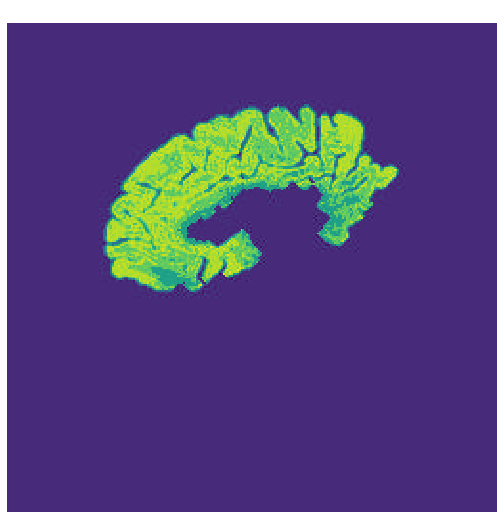

In [19]:
path = "C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\experiment\\"
plt.imsave(path + "hasil_perc15a.jpeg", segmented_image)
image = cv2.imread(path + "hasil_perc15a.jpeg", 0)
ShowImage('ambil',image,'rgb')

# All in One Row

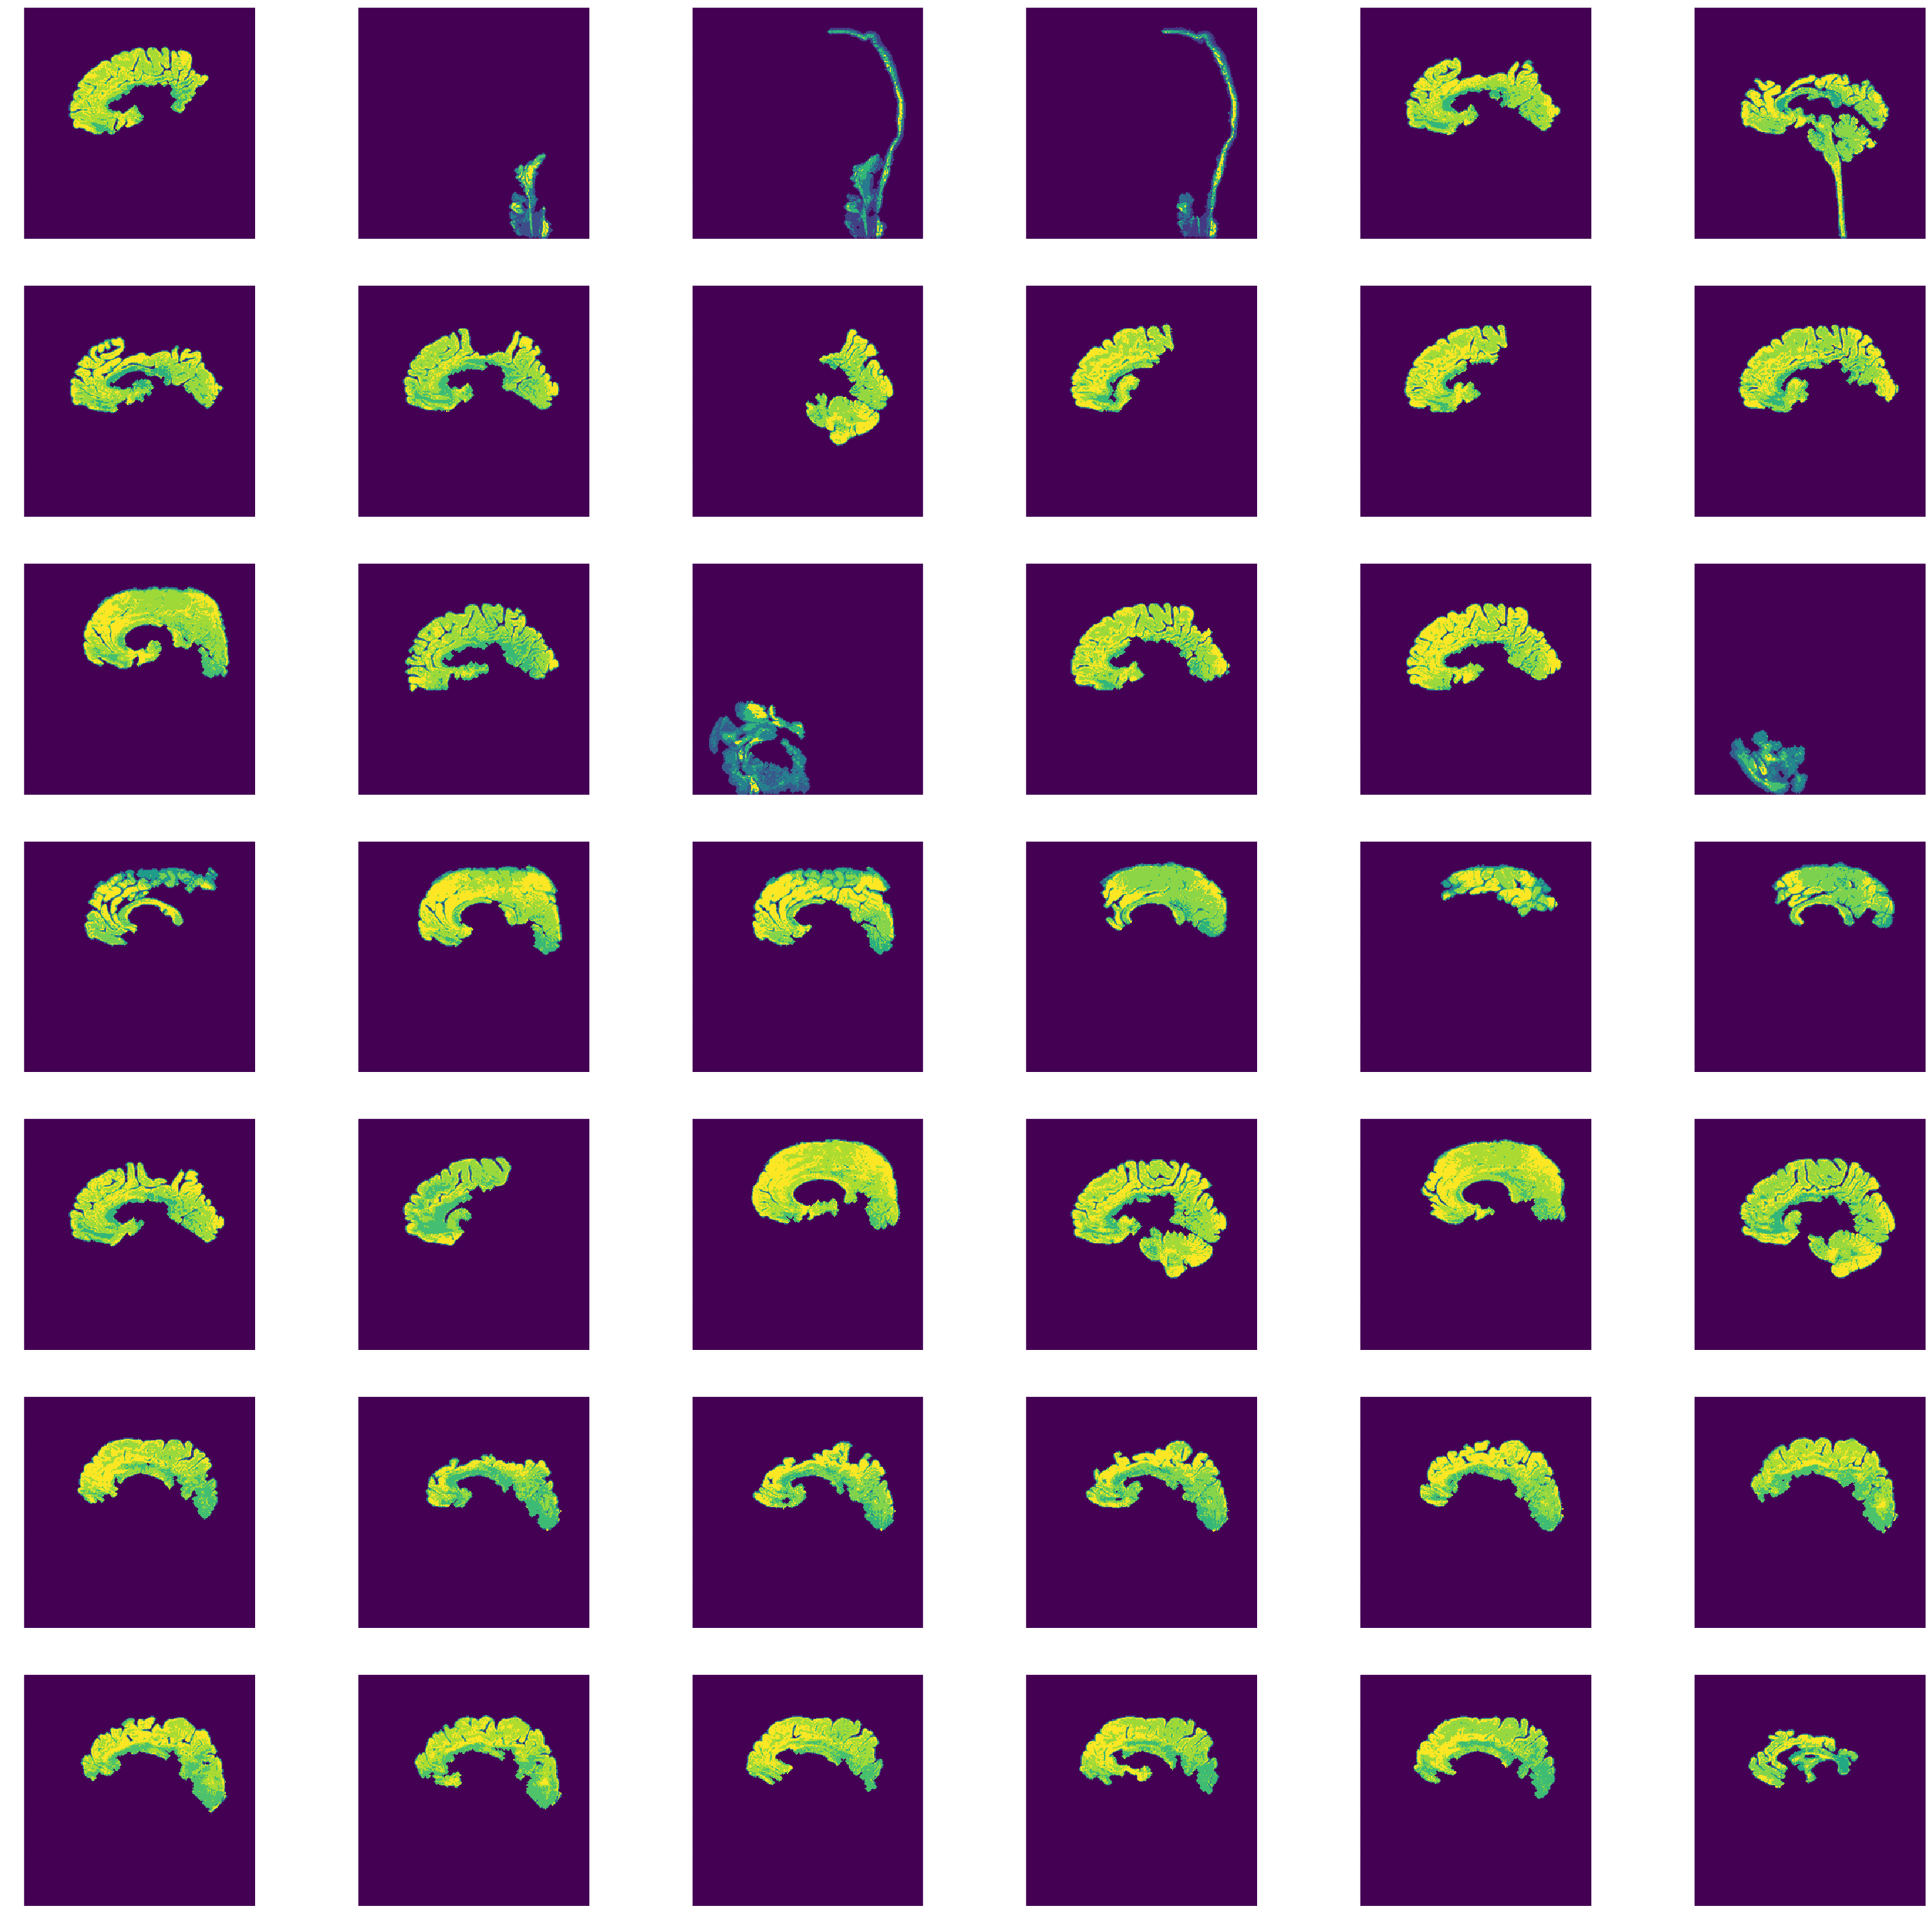

In [20]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\Simple_Brain_MRI_Segmentation\\dicom\\"
IMAGE_PATHS = os.listdir(basepath)

list_b = []
for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled

    adaptiveMean = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,115, 1)
    
    # kernel = np.ones((5, 5), np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

    erosion = cv2.erode(adaptiveMean,kernel,iterations = 2)

    foreground_value = 255
    mask = np.uint8(erosion == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    erosion = np.zeros_like(erosion)
    erosion[labels == largest_label] = foreground_value

    # kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE, kernel, iterations= 3)

    foreground_value = 255
    mask_closing = np.uint8(closing >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_closing, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    closing = np.zeros_like(closing)
    closing[labels == largest_label] = foreground_value

    # shape = np.ones((5, 5), np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 3)

    foreground_value = 255
    mask = np.uint8(dilation == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    dilation = np.zeros_like(dilation)
    dilation[labels == largest_label] = foreground_value


    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = dilation)
    brain_pixels = skull_stripped_image[dilation == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS
    
    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]

    segmented_image = np.zeros_like(dilation)
    segmented_image[dilation == foreground_value] = labels

    list_b.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_b[i])
plt.show()